<a href="https://colab.research.google.com/github/r0664975/Next-event-prediction-in-Learning-analytics/blob/main/Next_Event_Prediction_in_Learning_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Next Event Prediction in Learning Analytics

##Locating Drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


##Data Cleaning & Pre-Processing

In [ ]:
from datetime import datetime
import pandas as pd
import datetime as datetime

edx1 = pd.read_csv("/content/drive/MyDrive/content/data/Merode1.csv", sep =";")
edx2 = pd.read_csv("/content/drive/MyDrive/content/data/Merode2.csv", sep =";")
edx3 = pd.read_csv("/content/drive/MyDrive/content/data/Merode3.csv", sep =",")
edx = pd.concat([edx1, edx2, edx3], axis=0)

#Settings
pd.set_option('display.max_columns', None)

#Dropping non-student anonusernames
edx = edx[-edx["anonusername"].isin(["52d30c07", "db1c2251", "4af2572f", "3192eb9b",
                                     "e0a9f545", "e1b5d3e2", "1a2fbd20", "2900226c", 
                                     "e7cc62ba", "ef016da6", "df93ed4a"])]

#Selecting  events triggered by student interaction
edx = edx[edx["event_type"].isin(["edx.course.home.resume_course.clicked","edx.ui.lms.link_clicked","seq_goto","seq_next","edx.ui.lms.sequence.next_selected","seq_prev","edx.ui.lms.sequence.previous_selected",
                                    "page_close","edx.bookmark.accessed","edx.course.tool.accessed",
                                    "edx.forum.thread.viewed",
                                    "problem_save","problem_check","problem_graded","problem_show","problem_reset",
                                    "load_video","play_video","pause_video","seek_video","speed_change_video","stop_video",
                                    "edx.grades.problem.submitted"
                                    ])]

#Dropping events without specified "session"
edx = edx.dropna(subset=["session"])

#Shorten the time strings. (not rounded)
edx["time"] = edx["time"].map(lambda x: str(x)[:-13])

#Making Pandas timestamps
t=[]
for row in range(len(edx)):
  t.append(pd.Timestamp(edx.iloc[row, 8]))

#Changing every activity to a number using a dictionary

activtonumdict = {
    ##Certificate events
    #None

    ##Cohort events
    #None

    ##Course content completion events
    #None

    ##Content library interaction events
    #None

    ##Course navigation events
    "edx.course.home.resume_course.clicked":"1",
    #CLICK RESUME
    #Not documented
    "edx.ui.lms.link_clicked":"2",
    #SELECT LINK
    #User selects any hypertext link from the course content
    "seq_goto":"3",
    #CLICK NAVIGATION BAR
    #User selects any tab in the unit navigation bar
    "seq_next":"4",
    #NEXT PAGE
    #User selects “next” in the unit navigation bar AND STAYS IN SUBSECTION BY DOING SO
    "edx.ui.lms.sequence.next_selected":"5",
    #NEXT PAGE
    #User selects “next” in the unit navigation bar AND GOES FROM LAST UNIT IN SUBSECTION TO FIRST UNIT IN NEXT SUBSECTION
    "seq_prev":"6",
    #PREVIOUS PAGE
    #User selects “previous” in the unit navigation bar AND STAYS IN SUBSECTION BY DOING SO
    "edx.ui.lms.sequence.previous_selected":"7",
    #PREVIOUS PAGE
    #User selects “previous” in the unit navigation bar AND GOES FROM FIRST UNIT IN SUBSECTION TO LAST UNIT IN SUBSECTION
    "page_close":"8",
    #PAGE CLOSE
    #User closes the page

    ##Course resource events
    "edx.bookmark.accessed":"9",
    #CLICK BOOKMARK
    #User selects one of his bookmarks
    "edx.course.tool.accessed":"10",
    #CLICK COURSE TOOL HEADING
    #User clicks one of the links under the Course Tools heading such as “Bookmarks”, “Reviews”, or “Updates”.

    ##Discussion forum events
    #"edx.forum.thread.created":"X", Only happens once and will not make it to the final dataset
    #User creates new post
    "edx.forum.thread.viewed":"11",
    #User views a thread in the course discussions


    ##Drag and drop events (XBlock)
    #None

    ##Enrollment events
    #None

    ##Notes events
    #None

    ##Open response assessment events
    #None

    ##Peer instruction events
    #None

    ##Poll and survey events (XBlock)
    #None

    ##Pre-roll video interaction events
    #None

    ##Problem interaction events
    "problem_save":"12",
    #SAVE ANSWER OF A PROBLEM
    #User saves a problem
    "problem_check":"13",
    #SERVER PROBLEM CHECKED
    #Server successfully checked a problem
    "problem_graded":"14",
    #SERVER GRADES SUBMITTED
    #Server successfully graded after user submitted problem
    "problem_show":"15",
    #SHOW ANSWER OF A PROBLEM
    #User selected “show answer”
    "problem_reset":"16",
    #RESET PROBLEM
    #User selects “Reset” and the answer to a problem is reset

    ##Team related events
    #None

    ##Testing events for content experiments
    #None

    ##Textbook interaction events
    #None

    ##Third party content events
    #None

    ##Timed exam and proctored exam events
     #None

    ##Video interaction events
    "load_video":"17",
    #LOAD VIDEO
    #The video is fully rendered and ready to be played
    "play_video":"18",
    #PLAY VIDEO
    #User presses the play button to start a video
    "pause_video":"19",
    #PAUSE VIDEO
    #User presses the pause button to pause a video
    "seek_video":"20",
    #SEEK VIDEO
    #User clicks/drags the in-video playback bar
    "speed_change_video":"21",
    #SPEED CHANGE VIDEO
    #User selects different playing speed
    "stop_video":"22",
    #VIDEO COMPLETED
    #The video has reached its end

    ##Non /events
    "edx.grades.problem.submitted":"23",

    }

edx = edx.replace(activtonumdict)

#Number of students
print("Information about students in 'anonusername'")
print(edx.info())
print(edx["anonusername"].describe())

#Finalising the PandasDataFrame
edx["timestamps"] = t

edx = edx[["session", "event_type", "timestamps"]]
edx.describe()
edx.info()

#Renaming the columns to CaseID, ActivityID and CompleteTimestamp
namechangedict = {"session":"CaseID","event_type":"ActivityID","timestamps":"CompleteTimestamp"}
edx.rename(columns = namechangedict, inplace = True)

#Sorting values
edx = edx.sort_values(["CaseID", "CompleteTimestamp"], ascending = [True, True])

#Renaming cases and splitting (if time between events >6 hours)
lastCaseID = 0
teller = 1
for row in range(len(edx)):
  if lastCaseID == 0:
    lastCaseID = edx.iloc[row,0] # For the next loop
    edx.iloc[row,0] = teller
  else:
    if (lastCaseID == edx.iloc[row,0]) & ( pd.Timedelta(edx.iloc[row,2]-edx.iloc[row-1,2]).days *24 + pd.Timedelta(edx.iloc[row,2]-edx.iloc[row-1,2]).seconds / 3600 < 6 ):
      edx.iloc[row,0] = teller
    else:
      lastCaseID = edx.iloc[row,0]
      teller = teller + 1
      edx.iloc[row,0] = teller

#Only use cases/sequences between 3-200 events long.
case_length = edx["CaseID"].value_counts()
case_length = case_length[(case_length >= 3) & (case_length <= 200)].reset_index(drop=False)
edx = edx[edx["CaseID"].isin(case_length["index"])]
case_length = edx["CaseID"].value_counts()

#Save the new file as edxpddf.csv excluding the index column
edx.to_csv("/content/drive/MyDrive/content/data/edxpddf.csv", index=False)

Information about students in 'anonusername'
<class 'pandas.core.frame.DataFrame'>
Int64Index: 378660 entries, 1000 to 267948
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   accept_language    378660 non-null  object 
 1   context.course_id  378660 non-null  object 
 2   context.path       378660 non-null  object 
 3   context.user_id    378143 non-null  float64
 4   event_source       378660 non-null  object 
 5   event_type         378660 non-null  object 
 6   page               354873 non-null  object 
 7   referer            378660 non-null  object 
 8   time               378660 non-null  object 
 9   name               378660 non-null  object 
 10  session            378660 non-null  object 
 11  anonusername       378143 non-null  object 
dtypes: float64(1), object(11)
memory usage: 37.6+ MB
None
count       378143
unique          94
top       97f31049
freq         24497
Name: anonusername, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:183: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 378660 entries, 1000 to 267948
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   session     378660 non-null  object        
 1   event_type  378660 non-null  object        
 2   timestamps  378660 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 11.6+ MB


##Data Exploration

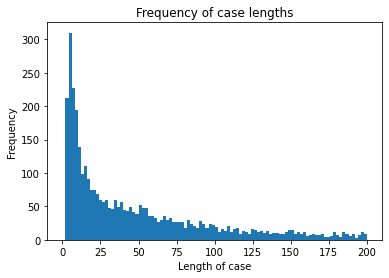

3      212
4      184
5      126
6      117
7      110
      ... 
195      2
196      5
197      6
198      4
199      4
Name: CaseID, Length: 195, dtype: int64


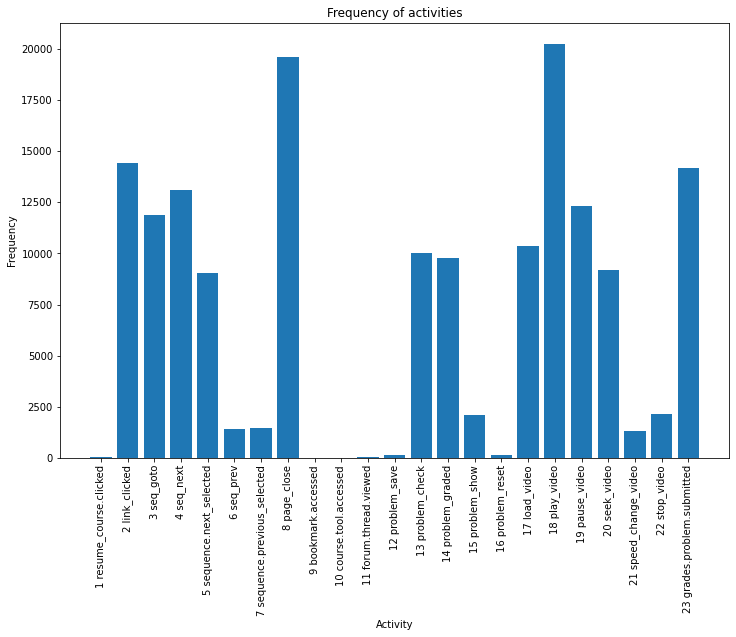

The number of individual activities is 23
1        38
2     14411
3     11895
4     13087
5      9033
6      1409
7      1446
8     19619
9         7
10       15
11       58
12      142
13    10020
14     9789
15     2111
16      150
17    10360
18    20254
19    12305
20     9166
21     1311
22     2126
23    14156
Name: ActivityID, dtype: int64


In [ ]:
#This analysis is identical to the helpdesk analysis with the exception of semantical differences.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 100)

edx = pd.read_csv("/content/drive/MyDrive/content/data/edxpddf.csv")

#Plot frequency of case lengths
case_length = edx["CaseID"].value_counts()

fig, ax = plt.subplots()
ax.hist(case_length, bins=100, range= [0,200])
ax.set_xlabel("Length of case")
ax.set_ylabel("Frequency")
ax.set_title("Frequency of case lengths")

plt.show()

print(case_length.value_counts().sort_index(ascending=True))

#Plot frequency of events/activities
activity_frequency = edx["ActivityID"].value_counts()

fig, ax = plt.subplots(figsize=(12,8))
ax.bar(activity_frequency.index, activity_frequency)
plt.xticks(rotation=90, ticks=range(1,24), labels = ["1 resume_course.clicked", "2 link_clicked", "3 seq_goto", "4 seq_next", "5 sequence.next_selected", "6 seq_prev", "7 sequence.previous_selected", "8 page_close",
                         "9 bookmark.accessed", "10 course.tool.accessed", "11 forum.thread.viewed", "12 problem_save", "13 problem_check", "14 problem_graded", "15 problem_show", "16 problem_reset",
                         "17 load_video", "18 play_video", "19 pause_video", "20 seek_video", "21 speed_change_video", "22 stop_video", "23 grades.problem.submitted"])
ax.set_xlabel("Activity")
ax.set_ylabel("Frequency")
ax.set_title("Frequency of activities")

plt.show()

print("The number of individual activities is " + str(len(activity_frequency)))
print(activity_frequency.sort_index(ascending=True))

##Model Learning

###Benchmark Model

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk
pd.set_option('display.max_columns', None)

data = pd.read_csv("/content/drive/MyDrive/content/data/edxpddf.csv")

list_of_CaseIDs = data["CaseID"].value_counts().sort_index().index
elems_per_fold = round(len(list_of_CaseIDs)/3)
#start_3rd_fold = list_of_CaseIDs[2*elems_per_fold]
#end_3rd_fold = list_of_CaseIDs[-1]

TPM_train = pd.DataFrame(index = range(1, 24), columns = range(1, 24)).fillna(0)
TPM_test = pd.DataFrame(index = range(1, 24), columns = range(1, 24)).fillna(0)

#Training on first 2 folds
for i in list_of_CaseIDs[:2*elems_per_fold]: #for i in data["CaseID"].value_counts().index:
  for j in range(1, len(data[data["CaseID"]==i])-1): #From 1 because the LSTM has minimum 2 prefixes before it starts predicting, but corrected by 1 because use of iloc (index counting)
    sequence = data[data["CaseID"]==i]["ActivityID"]
    TPM_train.loc[sequence.iloc[j], sequence.iloc[j+1]] = TPM_train.loc[sequence.iloc[j], sequence.iloc[j+1]] +1

print("TPM_train")
print(TPM_train)

totmax = 0
totsum = 0
predictingdict={}

for i in range(1,24):
  row = TPM_train.loc[i,:]
  print("event: " + str(i))
  print("max: " + str(row.max()))
  print("predict: " + str((row.argmax())+1))
  predictingdict[i] = (row.argmax())+1
  totmax = totmax + row.max()
  print("sum: " + str(row.sum()))
  totsum = totsum + row.sum()

print("totmax: " + str(totmax))
print("totsum: " + str(totsum))
print(predictingdict)

#Creating a row of y_true and a row y_pred
y_true = []
y_pred = []

#Test on 3rd fold
for i in list_of_CaseIDs[2*elems_per_fold:]:
  for j in range(1, len(data[data["CaseID"]==i])-1): #From 1 because the LSTM has minimum 2 prefixes before it starts predicting, but corrected by 1 because use of iloc (index counting)
    sequence = data[data["CaseID"]==i]["ActivityID"]
    y_true.append(sequence.iloc[j+1])
    y_pred.append(predictingdict[sequence.iloc[j]])
    TPM_test.loc[sequence.iloc[j], sequence.iloc[j+1]] = TPM_test.loc[sequence.iloc[j], sequence.iloc[j+1]] +1 #Not necessary

print(TPM_test)

pd.DataFrame(y_true).to_csv("/content/drive/MyDrive/content/data/benchtruepddf.csv", index=False)
pd.DataFrame(y_pred).to_csv("/content/drive/MyDrive/content/data/benchpredpddf.csv", index=False)


1165.0
1165
2330
3230
4896
TPM_train
    1     2     3     4     5    6    7     8   9   10  11  12    13    14  \
1    0     8     0     4     2    0    0     4   0   0   0   0     0     0   
2    5  1296   427   560   493   43   78  3588   1   1  11   2   201    14   
3    0   277  4120   610   362   41   57   234   0   0   0   5   167    39   
4    0   299   854  2648   897  298    3   417   0   0   0   5   466    94   
5    0    72    21    78   178    0   27  5312   0   0   1   0     8     0   
6    0    64    76   243     3  256   71    43   0   0   0   0    29     3   
7    0    18     8     1     6   16   21   823   0   0   0   0     0     0   
8    4  4711   664  1228  1719   78  565   760   0   6  15   6   268    11   
9    0     2     0     1     0    0    1     2   1   0   0   0     0     0   
10   0     4     0     0     0    0    0     0   3   0   0   0     0     0   
11   0    11     0     0     8    1    0     7   0   0   0   0     1     0   
12   0     1     4    11   

###LSTM Model

See separate Python 2 file containing LSTM model

##Results

###Benchmark Model

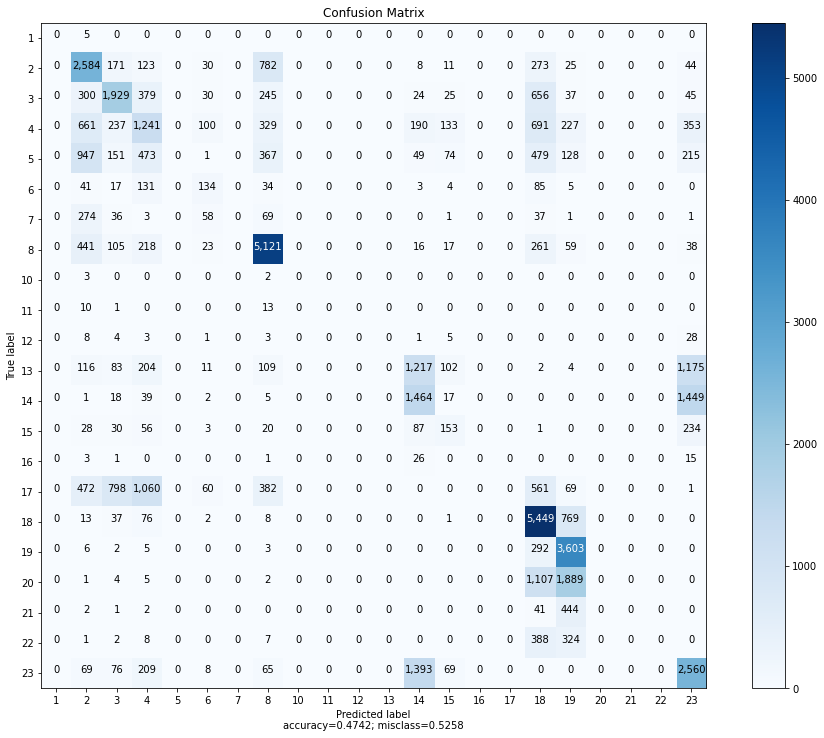

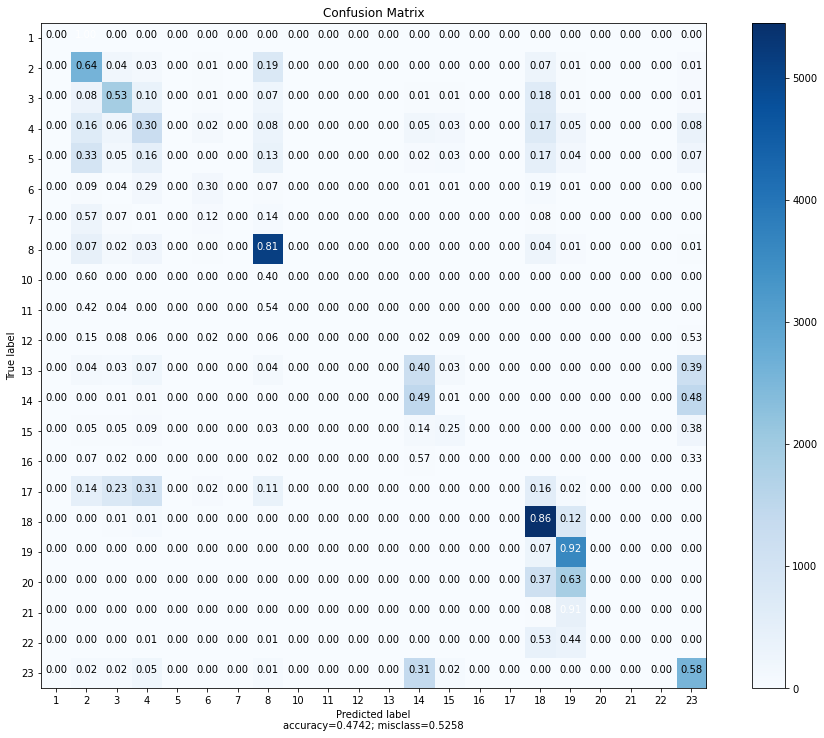

                              precision    recall  f1-score   support

     1 resume_course.clicked       0.00      0.00      0.00         5
              2 link_clicked       0.43      0.64      0.51      4051
                  3 seq_goto       0.52      0.53      0.52      3670
                  4 seq_next       0.29      0.30      0.30      4162
    5 sequence.next_selected       0.00      0.00      0.00      2884
                  6 seq_prev       0.29      0.30      0.29       454
7 sequence.previous_selected       0.00      0.00      0.00       480
                8 page_close       0.68      0.81      0.74      6299
     10 course.tool.accessed       0.00      0.00      0.00         5
      11 forum.thread.viewed       0.00      0.00      0.00        24
             12 problem_save       0.00      0.00      0.00        53
            13 problem_check       0.00      0.00      0.00      3023
           14 problem_graded       0.33      0.49      0.39      2995
             15 pro

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk
pd.set_option('display.max_columns', None)

y_true = pd.read_csv("/content/drive/MyDrive/content/data/benchtruepddf.csv")
y_pred = pd.read_csv("/content/drive/MyDrive/content/data/benchpredpddf.csv")

#Confusion Matrix

#-------------------------------------------------------------------------------------------------------------------
#Code from Calvin Duy Canh Tran

import numpy as np

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          save=''):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(13, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]), #"{:0.Xf}" forces X decimals
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('/content/drive/MyDrive/content/data/plot'+str(save)+'.jpg',bbox_inches='tight', dpi=400)
    plt.show()
  
#---------------------------------------------------------------------------------------------------------------------

confusion_matrix = sk.confusion_matrix(y_true, y_pred)

plot_confusion_matrix(confusion_matrix, target_names= ["1", "2", "3", "4", "5", "6", "7", "8",
                                                       "10", "11", "12", "13", "14", "15", "16",
                                                       "17", "18", "19", "20", "21", "22", "23"],
                      title="Confusion Matrix", normalize=False, save=1)
plot_confusion_matrix(confusion_matrix, target_names= ["1", "2", "3", "4", "5", "6", "7", "8",
                                                       "10", "11", "12", "13", "14", "15", "16",
                                                       "17", "18", "19", "20", "21", "22", "23"],
                      title="Confusion Matrix", normalize=True, save=2)


# Precision, Recall & F1-Score
print(sk.classification_report(y_true, y_pred, target_names = ["1 resume_course.clicked", "2 link_clicked", "3 seq_goto", "4 seq_next", "5 sequence.next_selected", "6 seq_prev", "7 sequence.previous_selected", "8 page_close",
                                                       "10 course.tool.accessed", "11 forum.thread.viewed", "12 problem_save", "13 problem_check", "14 problem_graded", "15 problem_show", "16 problem_reset",
                                                       "17 load_video", "18 play_video", "19 pause_video", "20 seek_video", "21 speed_change_video", "22 stop_video", "23 grades.problem.submitted"]))


###LSTM Model

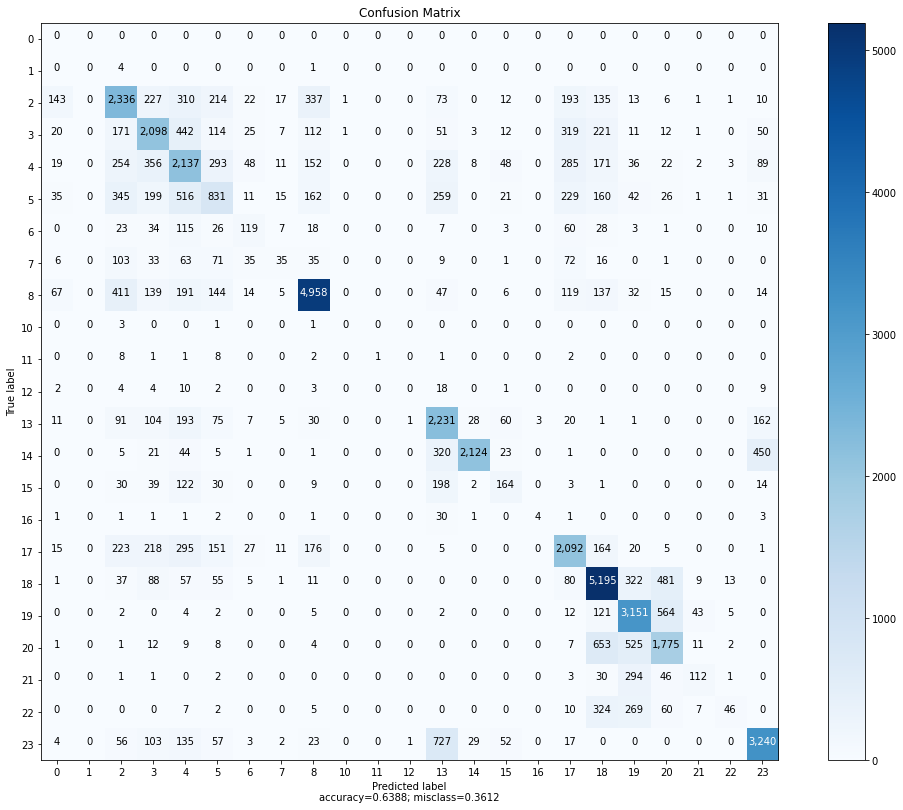

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide


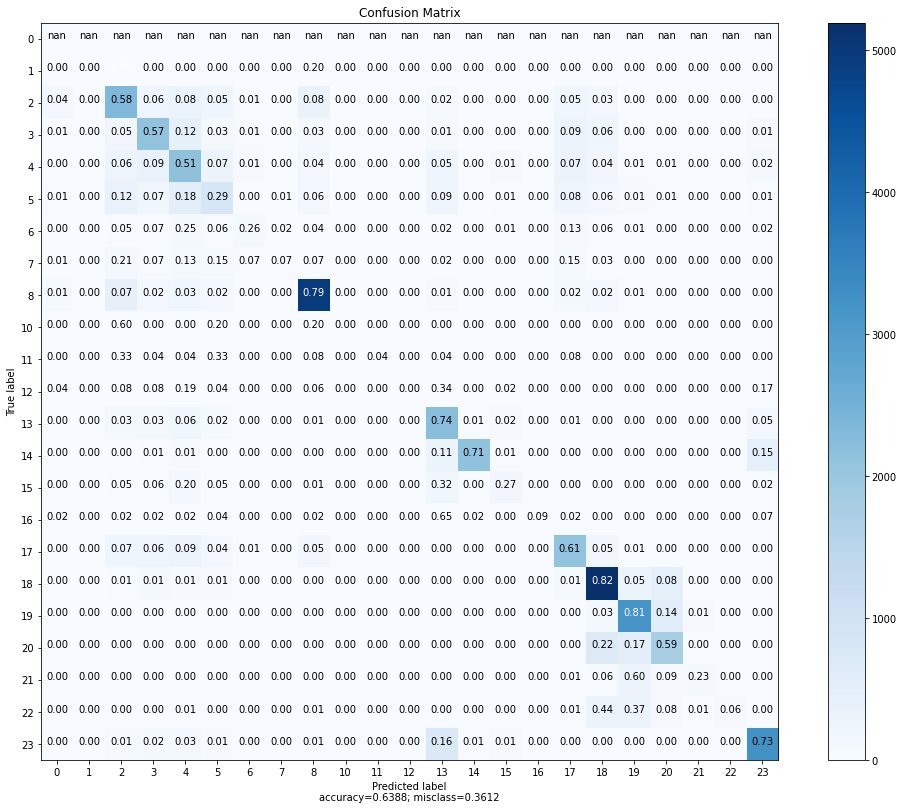

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                              precision    recall  f1-score   support

                       0 end       0.00      0.00      0.00         0
     1 resume_course.clicked       0.00      0.00      0.00         5
              2 link_clicked       0.57      0.58      0.57      4051
                  3 seq_goto       0.57      0.57      0.57      3670
                  4 seq_next       0.46      0.51      0.48      4162
    5 sequence.next_selected       0.40      0.29      0.33      2884
                  6 seq_prev       0.38      0.26      0.31       454
7 sequence.previous_selected       0.30      0.07      0.12       480
                8 page_close       0.82      0.79      0.80      6299
     10 course.tool.accessed       0.00      0.00      0.00         5
      11 forum.thread.viewed       1.00      0.04      0.08        24
             12 problem_save       0.00      0.00      0.00        53
            13 problem_check       0.53      0.74      0.62      3023
           14 probl

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


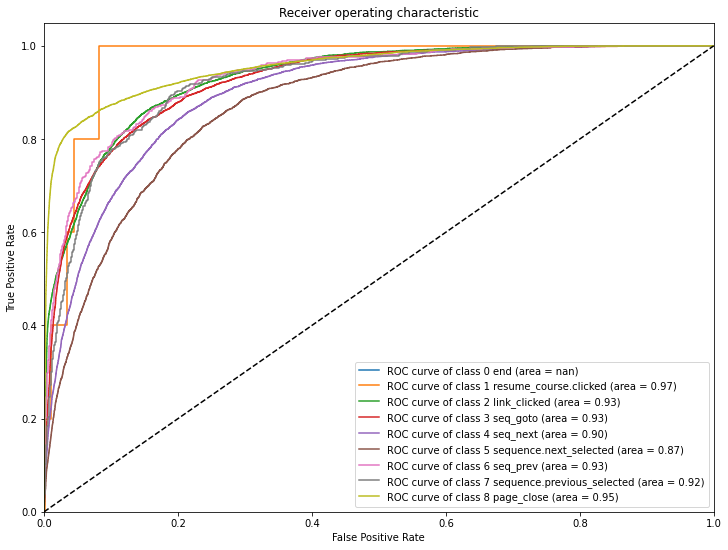

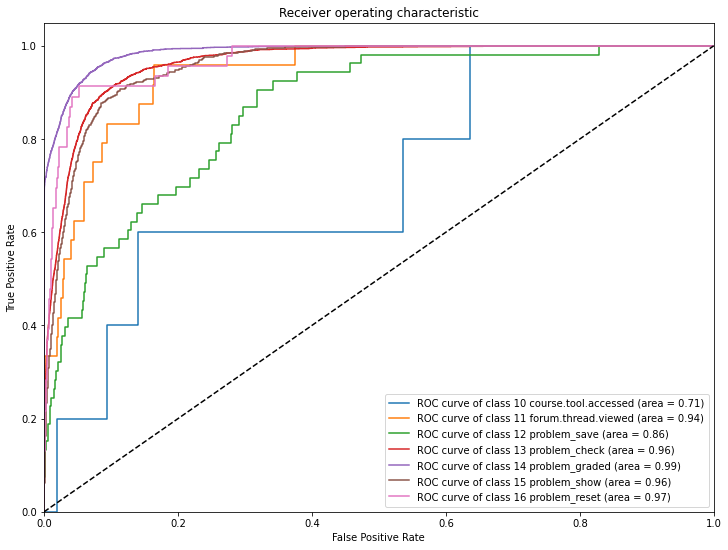

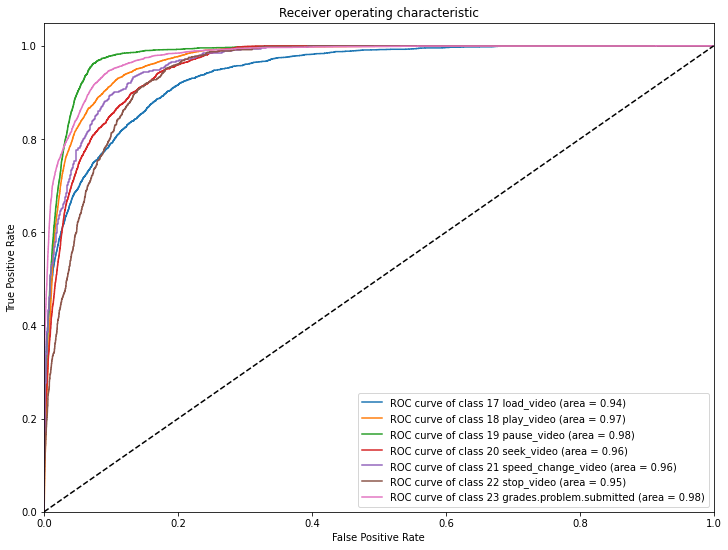

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk

#Settings
pd.set_option('display.max_columns', None)

originalpredictions = pd.read_csv("/content/drive/MyDrive/content/code/output_files/results/suffix_and_remaining_time_edxpddf.csv")
edxpddf = pd.read_csv("/content/drive/MyDrive/content/data/edxpddf.csv")

results = pd.DataFrame(columns=["Ground Truth", "Predicted"], index=range(len(originalpredictions)))

results = pd.DataFrame(columns=["Ground Truth", "Predicted"], index=range(len(originalpredictions)))
for row in range(len(originalpredictions)):
  results.iloc[row, 0] = originalpredictions.iloc[row,2][0]
  try: results.iloc[row, 1] = originalpredictions.iloc[row,3][0]
  except: results.iloc[row, 1] = 0 #Empty predictions occur when 0 was predicted

#Translate from Unicode to numbers
symboldf = pd.read_csv("/content/drive/MyDrive/content/data/symboldf.csv", sep=";")
symboldict = dict(zip(symboldf["symbol"], symboldf["event"]))
results = results.replace(symboldict)

# Event 9 is not present in test set nor is it ever predicted.
#print(results["Ground Truth"].value_counts().sort_index())
#print(results["Predicted"].value_counts().sort_index()) 

#Confusion Matrix

#-------------------------------------------------------------------------------------------------------------------
#Code from Calvin Duy Canh Tran

import numpy as np

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          save=""):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(14, 11))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if normalize: #Added manually
        thresh = 0.75
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]), #"{:0.Xf}" forces X decimals
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('/content/drive/MyDrive/content/data/plot'+str(save)+'.jpg',bbox_inches='tight', dpi=400)
    plt.show()

#---------------------------------------------------------------------------------------------------------------------

confusion_matrix = sk.confusion_matrix(results["Ground Truth"], results["Predicted"])

plot_confusion_matrix(confusion_matrix, target_names= ["0", "1", "2", "3", "4", "5", "6", "7", "8",
                                                       "10", "11", "12", "13", "14", "15", "16",
                                                       "17", "18", "19", "20", "21", "22", "23"],
                      title="Confusion Matrix", normalize=False, save=3)
plot_confusion_matrix(confusion_matrix, target_names= ["0", "1", "2", "3", "4", "5", "6", "7", "8",
                                                       "10", "11", "12", "13", "14", "15", "16",
                                                       "17", "18", "19", "20", "21", "22", "23"],
                      title="Confusion Matrix", normalize=True, save=4)


# Precision, Recall & F1-Score
print(sk.classification_report(results["Ground Truth"], results["Predicted"], target_names = ["0 end", "1 resume_course.clicked", "2 link_clicked", "3 seq_goto", "4 seq_next", "5 sequence.next_selected", "6 seq_prev", "7 sequence.previous_selected", "8 page_close",
                                                       "10 course.tool.accessed", "11 forum.thread.viewed", "12 problem_save", "13 problem_check", "14 problem_graded", "15 problem_show", "16 problem_reset",
                                                       "17 load_video", "18 play_video", "19 pause_video", "20 seek_video", "21 speed_change_video", "22 stop_video", "23 grades.problem.submitted"]))


# ROC and AUC-Scores, using code from Sklearn website
y_score = pd.read_csv("/content/drive/MyDrive/content/code/output_files/results/detailedpredictions.csv" , sep=',')
y_score = y_score.iloc[:,1:] #First column is all 0's, because of transpose done in the evaluation code
y_test = results["Ground Truth"]

    #Compute the ROC and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 24
activities = ["0 end", "1 resume_course.clicked", "2 link_clicked", "3 seq_goto", "4 seq_next", "5 sequence.next_selected", "6 seq_prev", "7 sequence.previous_selected", "8 page_close",
              "9 bookmark.accessed", "10 course.tool.accessed", "11 forum.thread.viewed", "12 problem_save", "13 problem_check", "14 problem_graded", "15 problem_show", "16 problem_reset",
              "17 load_video", "18 play_video", "19 pause_video", "20 seek_video", "21 speed_change_video", "22 stop_video", "23 grades.problem.submitted"]

   #Make y_testlong by making y_test binary for each class
y_testlong = (y_test == 0)*1
for i in range(1, n_classes+1):
    y_testlong = pd.concat([y_testlong, ((y_test == i)*1) ], axis=1)
y_testlong.columns = range(n_classes + 1)

for i in range(n_classes):
    fpr[i], tpr[i], _ = sk.roc_curve(y_testlong.iloc[:, i], y_score.iloc[:, i])
    roc_auc[i] = sk.auc(fpr[i], tpr[i])

  #Plot ROC curve in 3 graphs
plt.figure(figsize=(12, 9))
for i in range(9):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                     ''.format(activities[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('/content/drive/MyDrive/content/data/ROC1.jpg',bbox_inches='tight', dpi=400)
plt.show()

#---------------------------------------------
plt.figure(figsize=(12, 9))
for i in range(10,17):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                     ''.format(activities[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('/content/drive/MyDrive/content/data/ROC2.jpg',bbox_inches='tight', dpi=400)
plt.show()

#---------------------------------------------
plt.figure(figsize=(12, 9))
for i in range(17,n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                     ''.format(activities[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('/content/drive/MyDrive/content/data/ROC3.jpg',bbox_inches='tight', dpi=400)
plt.show()
